**Image classification from scratch**

In [ ]:
NAME ='Abu Tyeb Azad'
WSU_ID = 'Q688C867'

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Image data is fetched using 'curl'

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  72.3M      0  0:00:10  0:00:10 --:--:-- 77.1M


In [ ]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip   PetImages  'readme[1].txt'   sample_data


This is a cat/dog classifier

In [ ]:
!ls PetImages

Cat  Dog


Images that are not properly encoded are corrupted. Those images are removed from dataset to ensure quality of data

In [ ]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images



*   **Image is converted into a square matrix of size 180x180 for less computation without lossing important information**
*   **A batch size of 128 is used which means during training, the weights will be updated NOT after each image pass, but after passing each bucket(batch) of images where bucket size is 128. This is used because 'mini-batch gradient descent' performs better (converges well) than stochastic gradient descent' algorithm**
* **80% of training data is used for training, remaining 20% for validation**
* **A seed is used to enable reproducing the same random split**


In [ ]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


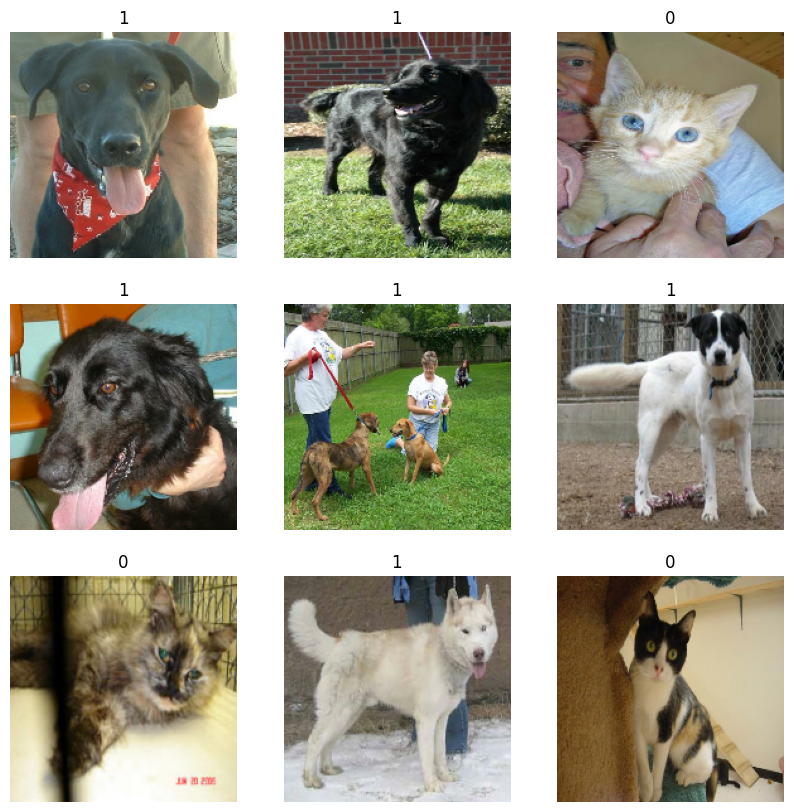

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

**Data augmentation is used to add variation is dataset to avoid overfitting and better generalization during inferring output using real-world (test) data**

*   **Horizontal flip changes the pose of randomly chosen objects (in this case cat/dog image) from left-to-right or from right-to-left**
*   **Random rotation of factor 0.1 changes poses of randomly chosen images in an angle range [-0.1x180, +0.1x180] = [-18, +18] degress**



In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

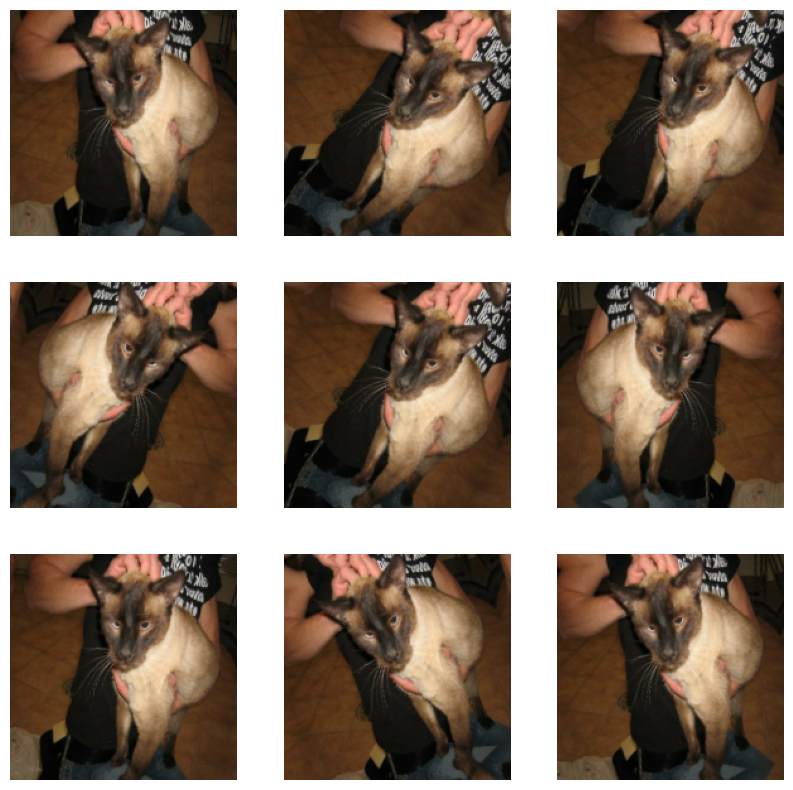

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

Model Architecture


*   The rgb images pixel values are converted within a range of [0,1]

*   3 residual blocks are used where the projection of input tensor (generated using a convolution operation) to the residual block is added to the output tensor (256/512/728) of the residual block. This prevents performance degradation when no. of layers in the network is increased

* Convolution layers with batch normalization is used to generate feature maps

* In hidden layers, relu() activation is used to ensure non-linearity

* Before passing to the last layer (dense layer) average pooling is executed and the activation functions suitable for classification (sigmoid [binary] /  softmax [multi-class]) are used.

* A dropout layer is used that deactivates 50% of neurons

* For this particular dataset, sigmoid function is used since only 2 classes (dog, cat) are present in the dataset



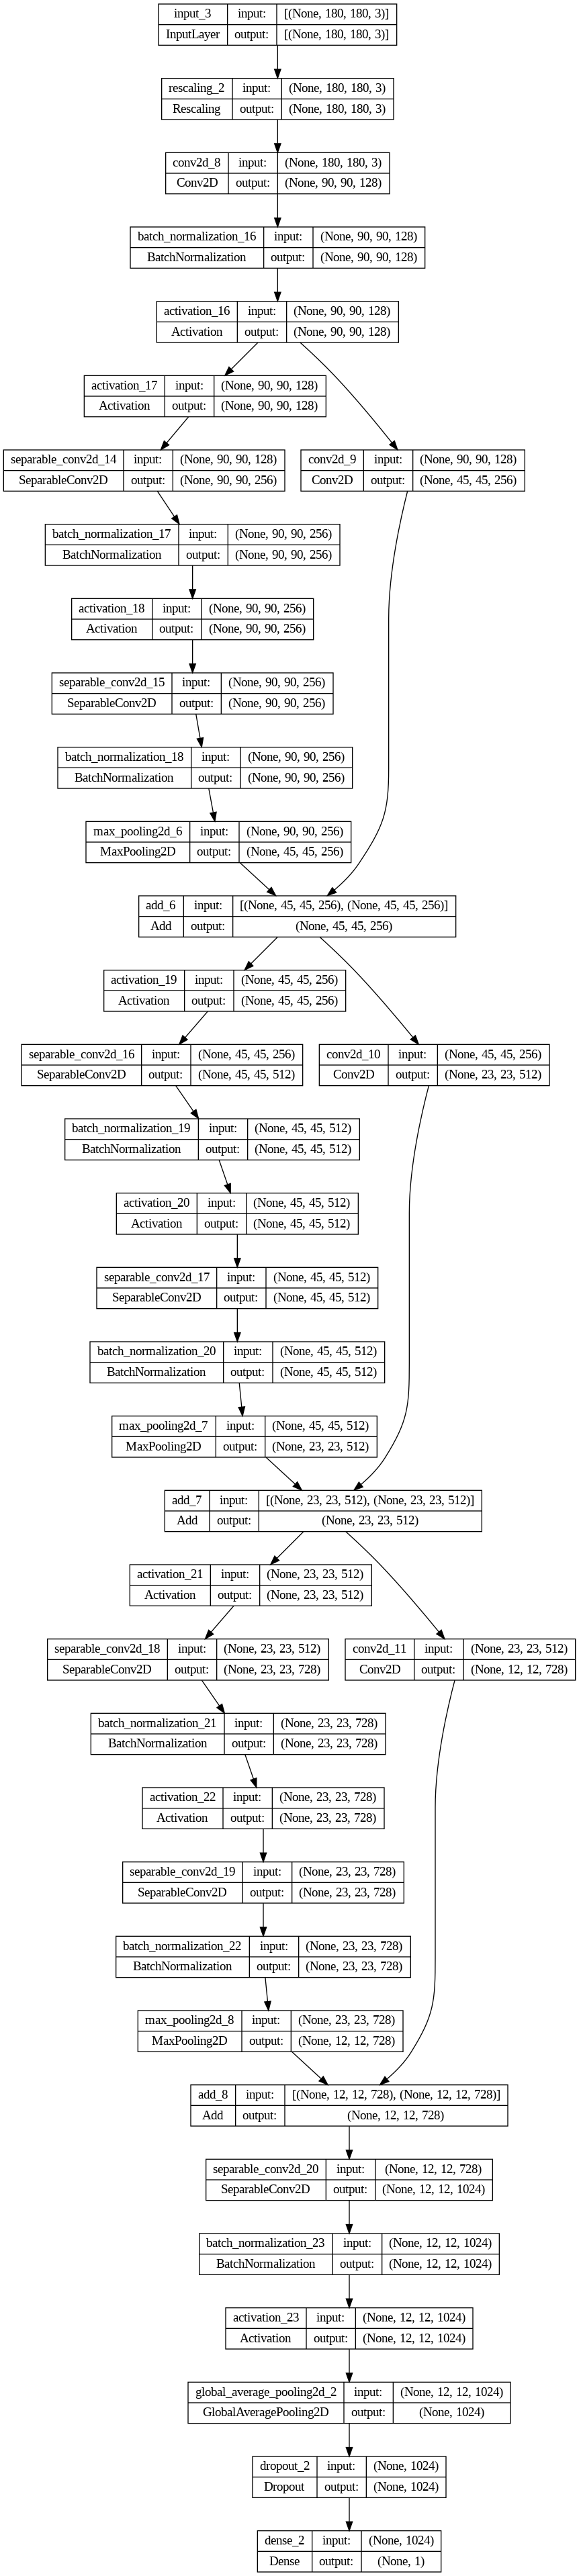

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

 Training



*   Adam optimizer (have momentum and other properties that are missing in gradient descent) is used
*   Binary cross entropy is used to calculate loss

*   Accuracy is used as metric to keep track of performance during training



In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
147/147 [==============================] - 239s 2s/step - loss: 0.6376 - accuracy: 0.6489 - val_loss: 1.0534 - val_accuracy: 0.4957
Epoch 2/25
147/147 [==============================] - 229s 2s/step - loss: 0.4980 - accuracy: 0.7641 - val_loss: 2.0401 - val_accuracy: 0.4957
Epoch 3/25
147/147 [==============================] - 231s 2s/step - loss: 0.3901 - accuracy: 0.8248 - val_loss: 1.5984 - val_accuracy: 0.4957
Epoch 4/25
147/147 [==============================] - 231s 2s/step - loss: 0.3299 - accuracy: 0.8575 - val_loss: 0.5243 - val_accuracy: 0.7396
Epoch 5/25
147/147 [==============================] - 230s 2s/step - loss: 0.2819 - accuracy: 0.8829 - val_loss: 0.4225 - val_accuracy: 0.8270
Epoch 6/25
147/147 [==============================] - 230s 2s/step - loss: 0.2481 - accuracy: 0.8960 - val_loss: 0.2649 - val_accuracy: 0.8919
Epoch 7/25
147/147 [==============================] - 231s 2s/step - loss: 0.2232 - accuracy: 0.9080 - val_loss: 0.2976 - val_accuracy: 0.8736

In [ ]:
all_training_loss = history.history['loss']
all_validation_loss = history.history['val_loss']

In [ ]:
print(all_training_loss)
print(all_validation_loss)

[0.6375573873519897, 0.4979839324951172, 0.3901002109050751, 0.32993248105049133, 0.28192517161369324, 0.24808360636234283, 0.223187655210495, 0.19574867188930511, 0.17822949588298798, 0.16274143755435944, 0.14499202370643616, 0.13351784646511078, 0.13455766439437866, 0.12066318094730377, 0.11636798083782196, 0.114621601998806, 0.10492754727602005, 0.10585293173789978, 0.10102755576372147, 0.09675569087266922, 0.08889450877904892, 0.0883830264210701, 0.09069810062646866, 0.07861511409282684, 0.08064009249210358]
[1.05343496799469, 2.0401229858398438, 1.5983647108078003, 0.5243152976036072, 0.4225216507911682, 0.26490381360054016, 0.29755058884620667, 0.2231425791978836, 0.7583948969841003, 0.4531640112400055, 0.19382472336292267, 0.35275790095329285, 0.17644648253917694, 0.2027420699596405, 0.33640047907829285, 0.4052335321903229, 0.20725584030151367, 0.174099862575531, 0.11866872012615204, 0.15226052701473236, 0.20104855298995972, 0.1692129224538803, 0.14377142488956451, 0.09936759620

Initially validation loss was higher than training loss. Then as training continued for more epochs, gradually validation loss started to go down. If training loss continues to go down but validation loss starts to go up, this is a possible sign of overfitting.

-No. of epochs is an important hyperparameter that differentiates between a well-trained and over-trained model.

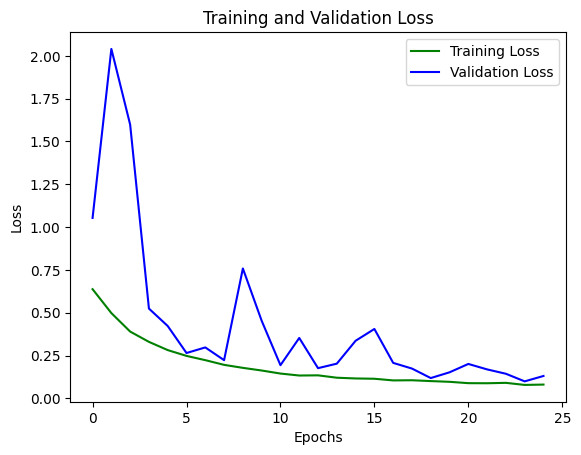

In [ ]:
# Plot the training and validation loss
epochs = range(len(all_training_loss))
plt.plot(epochs, all_training_loss, color='g', label='Training Loss')
plt.plot(epochs, all_validation_loss, color='b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Sample Prediction

1/1 [==============================] - 0s 90ms/step
This image is 96.36% cat and 3.64% dog.


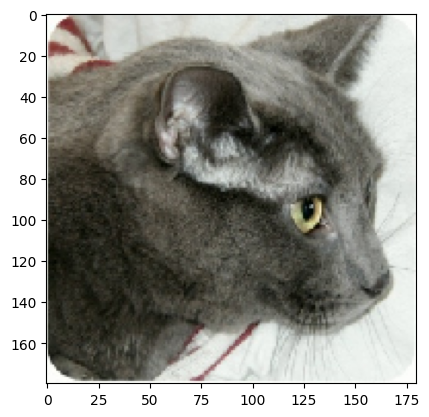

In [ ]:
img = keras.utils.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")